In [138]:
import datetime
import pandas as pd
import numpy as np
from fbprophet import Prophet

def dateparse (time_in_secs):    
    dt = datetime.datetime.fromtimestamp(float(time_in_secs))
    return dt.replace(hour=0, minute=0, second=0, microsecond=0)

df = pd.read_csv('bitcoin_trade_history.csv' ,parse_dates=['ds'], date_parser=dateparse,  usecols=["ds", "y"]) #nrows=10000
df.head()

,ds,y
0,2011-01-06,0.24990
1,2011-01-06,0.25499
2,2011-01-06,0.25499
3,2011-01-10,0.27100
4,2011-01-12,0.26000


In [139]:
dates = [ ]
high_values = [ ]
dates.append(df['ds'][0])
high_values.append(df['y'][0])
for x in range(1, len(df['ds'])):
    if (df['ds'][x] > dates[len(dates)-1]):
        dates.append(df['ds'][x])
        high_values.append(df['y'][x])
    elif (df['y'][x] > high_values[len(dates)-1]):
        high_values[len(dates)-1] = df['y'][x]
               
dfc = pd.DataFrame({'ds': dates,'y': high_values})
dfc.head()

,ds,y
0,2011-01-06,0.25499
1,2011-01-10,0.27100
2,2011-01-12,0.26000
3,2011-01-13,0.28519
4,2011-01-14,0.29900


In [140]:
m = Prophet()
m.fit(dfc)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\yo\appdata\local\programs\python\python36-32\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [141]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2612,2019-02-25
2613,2019-02-26
2614,2019-02-27
2615,2019-02-28
2616,2019-03-01


In [142]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2612,2019-02-25,15717.096865,14336.826246,17062.984098
2613,2019-02-26,15736.982273,14261.369639,17128.819973
2614,2019-02-27,15763.978108,14280.874848,17146.622864
2615,2019-02-28,15781.768964,14331.296397,17170.840768
2616,2019-03-01,15827.051125,14392.102244,17186.392894


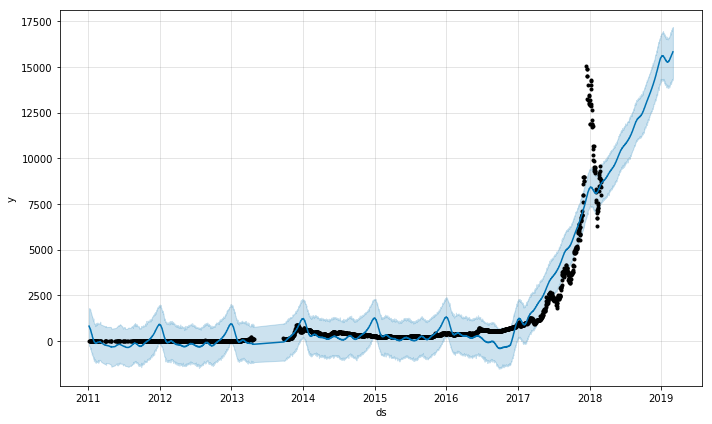

In [143]:
m.plot(forecast);